/Users/rashmigautam/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


----------------------------------------------------------------
LogisticRegression
AUC (fold 1/1): 0.991780
Mean AUC: 0.991780
[[30580  1710]
 [  853 88060]]
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     32290
           1       0.98      0.99      0.99     88913

    accuracy                           0.98    121203
   macro avg       0.98      0.97      0.97    121203
weighted avg       0.98      0.98      0.98    121203

----------------------------------------------------------------
DecisionTrees
AUC (fold 1/1): 0.999892
Mean AUC: 1.991671
[[32283     7]
 [    0 88913]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     32290
           1       1.00      1.00      1.00     88913

    accuracy                           1.00    121203
   macro avg       1.00      1.00      1.00    121203
weighted avg       1.00      1.00      1.00    121203

---------------------------------

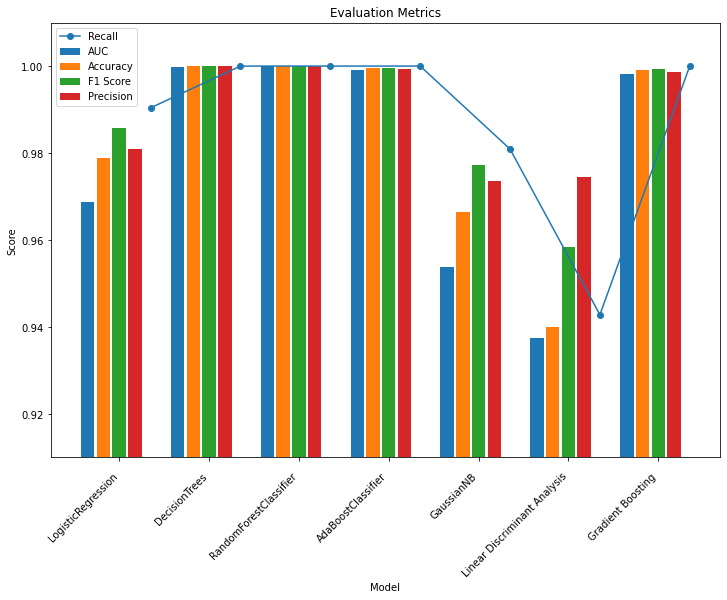

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt

outputformat = "%Y/%m/%d"
inputformat = "%Y-%m-%d"

#Import the preprocessed MOOC data file for Model Building
X = pd.read_csv("preprocessed_file.csv")

#Bayesian Ridge regression
def fillna_knn_reg( df, base, target, fraction=1, threshold = 10, n_neighbors=5):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    #print(threshold,"\n",fraction,"\n",n_neighbors)
    miss = df[target].isnull()
    notmiss = ~miss 
    
    X_target = df.loc[ notmiss, whole ] 
    Y =  X_target[ target ]
    X = X_target[ base  ] 
    X_train,X_test,Y_train,Y_test =train_test_split(X,Y,test_size = 0.2,random_state = 5)

    #print( 'fitting' )
    
    n_neighbors = n_neighbors
    clf =BayesianRidge()
    clf.fit( X, Y ) 
    #print( 'predicting' )
    
   # print("Fit a model X_test and claculate Mean Squared Error with Y_test:")
   # print(np.mean((Y_test-clf.predict(X_test))** 2))

    Z = clf.predict(df.loc[miss, base]) 
   # print( 'writing result to df' )    
    df.loc[ miss, target ]  = Z

#function to convert string to int

def convertstring2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

   # print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    #print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
   # print('recover the nan value')
    return enc

convertstring2int( df = X,target = 'grade' )
convertstring2int( df = X,target = 'LoE_DI' )
convertstring2int( df = X,target = 'final_cc_cname_DI' )
convertstring2int( df = X,target = 'course_id' )


fillna_knn_reg( df = X,
                 base = [  'course_id','certified','explored','grade','LoE_DI','viewed','final_cc_cname_DI'] ,
                  target = 'ndays_act', fraction = 0.2, n_neighbors = 1)

fillna_knn_reg( df = X,
                base = [  'certified','explored','grade','LoE_DI','viewed','final_cc_cname_DI'] ,
                target = 'nchapters',fraction = 0.2,n_neighbors = 1)

fillna_knn_reg( df = X,
                base = [   'certified','explored','grade','LoE_DI','viewed','final_cc_cname_DI','ndays_act'] ,
                target = 'nevents',fraction = 0.2,n_neighbors = 1)

fillna_knn_reg( df = X,
                base = [  'certified','nevents'] ,
                target = 'nplay_video',fraction = 0.2,n_neighbors = 1)

X = X.dropna()

file = "postprocessed_file.csv"
X.to_csv(file)

#print("---print(df.describe())")

#print(X.describe())

df_majority = X[X.certified==0]
df_minority = X[X.certified==1]
#print("-------df_majority------")
#print(df_majority)
#print("-------df_minority------")
#print(df_minority)

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                replace=True,     # sample with replacement
                                 n_samples=444509,    # to match majority class
                                random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
#print("-------df_upsampled------")
#print(df_upsampled)
#print(df_upsampled.certified.value_counts())
#print(df_upsampled.isnull().sum())


def Apply_Models( df, base, target):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    miss = df[target].isnull()
    notmiss = ~miss 
    
    X_target = df.loc[ notmiss, whole ] 
    enc = OneHotEncoder()
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]

    Y =  X_target[ target ]
    X = X_target[ base  ] 


    #Testing all models
    from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score
    from sklearn.neural_network import MLPClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
    from sklearn.svm import SVC
    from sklearn import model_selection
    from sklearn.metrics import classification_report, confusion_matrix
    from sklearn.tree import _tree
    classifiers =[LogisticRegression(), DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(solver="svd", store_covariance=True),
    GradientBoostingClassifier()]
    log_reg = LogisticRegression(max_iter=1000)
    #names = ["LR","DT","RF","AB","GNB","LDA","GB"]
    names = ["LogisticRegression","DecisionTrees","RandomForestClassifier","AdaBoostClassifier","GaussianNB","Linear Discriminant Analysis","Gradient Boosting"]
    
    from sklearn import metrics, preprocessing
    from sklearn.model_selection import train_test_split
    mean_auc = 0.0
    n = 1 
    for i in range(n):
    # for each iteration, randomly hold out 20% of the data as CV set
        X_train, X_test, y_train, y_test = train_test_split(
                X, Y, test_size=.20, random_state=i*48)
    # iterate over classifiers
        accs = {}
        aucs = {}
        f1s = {}
        precisions = {}
        recalls = {}
    
        for name, clf in zip(names, classifiers):
            clf.fit(X_train, y_train)
            y_pred_clf = clf.predict(X_test)
            auc = roc_auc_score(y_test, y_pred_clf)
            acc = accuracy_score(y_test, y_pred_clf)
            f1 = f1_score(y_test, y_pred_clf)
            precision = precision_score(y_test, y_pred_clf)
            recall = recall_score(y_test, y_pred_clf)
            cf = confusion_matrix(y_test, y_pred_clf)
            clf_rp = classification_report(y_test, y_pred_clf)
            preds = clf.predict_proba(X_test)[:, 1]
              
            # compute AUC metric for this CV fold
            fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
            roc_auc = metrics.auc(fpr, tpr)
            print("----------------------------------------------------------------") 
            print(name)
            print("AUC (fold %d/%d): %f" % (i + 1, n, roc_auc))
            mean_auc += roc_auc
            print("Mean AUC: %f" % (mean_auc/n))
            print(cf)
            print(clf_rp)
            accs[name] = acc
            aucs[name] = auc
            f1s[name] = f1
            precisions[name] = precision
            recalls[name] = recall
            
              
    print('\nAccuracies:')
    for name, acc in accs.items():
        print("%20s | Accuracy: %0.10f" % (name, acc))        
     
    print('\nAUC Scores:')
    for name, auc in aucs.items():
        print("%20s | AUC: %0.10f" % (name, auc))
    
    print('\nF1 Scores:')
    for name, f1 in f1s.items():
        print("%20s | F1: %0.10f" % (name, f1))
    
    print('\nPrecision Scores:')
    for name, precision in precisions.items():
        print("%20s | Precision: %0.10f" % (name, precision))
    
    print('\nRecall Scores:')
    for name, recall in recalls.items():
        print("%20s | Recall: %0.10f" % (name, recall))

    # Define the models and metrics
    print("--------------------------Plot Models and Metrics-------------------------------")
    models = aucs.keys()
    metrics = ['AUC', 'Accuracy', 'F1 Score', 'Precision', 'Recall']
    scores = [aucs, accs, f1s, precisions, recalls]

    # Set the width of each bar
    bar_width = 0.15

    # Set the position offset for each metric
    offsets = np.linspace(-0.35, 0.35, len(metrics))

    # Create a figure and axis object
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each metric
    for i, metric in enumerate(metrics):
        x_pos = np.arange(len(models)) + offsets[i]
        if metric == 'Recall':
            ax.plot(x_pos, scores[i].values(), marker='o', label=metric)
        else:
            ax.bar(x_pos, scores[i].values(), width=bar_width, label=metric)

    # Set the x-axis ticks and labels
    ax.set_xticks(np.arange(len(models)))
    ax.set_xticklabels(models, rotation=45, ha='right') # Rotate and align labels to the right


    # Set the axis labels and legend
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.set_title('Evaluation Metrics')
    ax.legend()

    # Set the y-axis limits
    ax.set_ylim([0.91, 1.01])
    
    # Adjust the padding
    ax.tick_params(axis='x', pad=10)

    
    # Save the plot to a file
    plt.savefig('evaluation_metrics.png', dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()
    
    

Apply_Models( df = df_upsampled,
                  base = ['explored','LoE_DI','viewed','final_cc_cname_DI','grade','gender','nplay_video','ndays_act','nevents','nchapters','course_id'] ,
                  target = 'certified')

